# IMAGE WARPING and MOSAICING

In [1]:
import cv2

import numpy as np
import skimage.io as skio

from skimage.draw import polygon
from Utils.ImagePointSet import ImagePointSet
from scipy.interpolate import griddata

## Recover Homographies

In [2]:

from matplotlib import pyplot as plt

# Note: x = column, y = row
def computeProjectionMatrix(src_points, dest_points):
    # Stack them horizontally so least squares gives a nice 3x3 matrix
    homogenous_src_points = np.concatenate([src_points, np.ones((src_points.shape[0], 1))], axis=1)
    homogenous_dest_points = np.concatenate([dest_points, np.ones((dest_points.shape[0], 1))], axis=1)
    return np.linalg.lstsq(homogenous_src_points, homogenous_dest_points, rcond=None)[0].T

# Used to verify method
def wrap_image_with_cv2(image, projection_matrix):
    h, w, _ = image.shape
    output_size = (w, h)
    
    wrapped_image = cv2.warpPerspective(image, projection_matrix, output_size)
    
    return wrapped_image

def warp_image(image, projection_matrix):
    h, w, _ = image.shape
    x = np.linspace(0, w-1, w)
    y = np.linspace(0, h-1, h)
    x, y = np.meshgrid(x, y)
    homogenous_coords = np.vstack((x.flatten(), y.flatten(), np.ones(x.size)))
    
    warped_homogenous_coords = np.dot(np.linalg.inv(projection_matrix), homogenous_coords)
    warped_coords = warped_homogenous_coords / warped_homogenous_coords[2]
    warped_x_min, warped_y_min = np.min(warped_coords[0]), np.min(warped_coords[1])
    
    warped_x = warped_coords[0] - warped_x_min if warped_x_min < 0 else warped_coords[0]
    warped_y = warped_coords[1] - warped_y_min if warped_y_min < 0 else warped_coords[1]
    
    warped_image = griddata(
        (homogenous_coords[0], homogenous_coords[1]),
        image.reshape(-1, 3),
        (warped_x, warped_y),
        method='linear',
        fill_value=0,
        rescale=True
    )
    
    return warped_image.reshape(h, w, 3)

In [22]:
hallway0_hallway1 = ImagePointSet("hallway/hallway1_hallway2.json")
hallway0_hallway1_projection_matrix = computeProjectionMatrix(hallway0_hallway1.points[0], hallway0_hallway1.points[1])
warped_hallway0_hallway1_image = warp_image(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix)
print(warped_hallway0_hallway1_image.shape)

ipad_image_set = ImagePointSet("ipad_ipad.json")
ipad_image_set_matrix = computeProjectionMatrix(ipad_image_set.points[0], ipad_image_set.points[1])
rectified_ipad_image = warp_image(ipad_image_set.images[0], ipad_image_set_matrix)

hallway1_rectify_image_set = ImagePointSet("hallway/hallway4_rectify.json")
hallway1_rectify_set_matrix = computeProjectionMatrix(hallway1_rectify_image_set.points[0], hallway1_rectify_image_set.points[1])
rectified_hallway1_rectify_image = warp_image(hallway1_rectify_image_set.images[0], hallway1_rectify_set_matrix)

_, axes = plt.subplots(2, 3, figsize=(12, 4))
axes[0, 0].imshow(hallway0_hallway1.images[0])
axes[0, 1].imshow(ipad_image_set.images[0])
axes[0, 2].imshow(hallway1_rectify_image_set.images[0])
axes[1, 0].imshow(warped_hallway0_hallway1_image)
axes[1, 1].imshow(rectified_ipad_image)
axes[1, 2].imshow(rectified_hallway1_rectify_image)


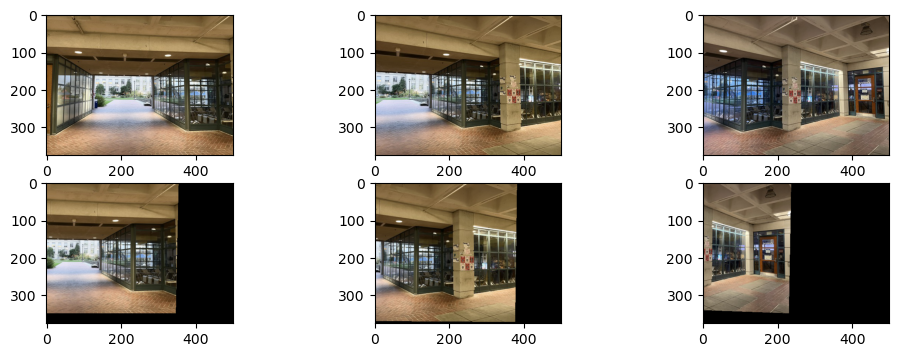

In [20]:
hallway_point_sets = [
    ImagePointSet("hallway/hallway1_hallway2.json"),
    ImagePointSet("hallway/hallway2_hallway3.json"),
    ImagePointSet("hallway/hallway3_hallway4.json")
]
hallway_projection_matrix_list = [computeProjectionMatrix(pt_set.points[0], pt_set.points[1]) for pt_set in hallway_point_sets]
warped_hallway_projections = [warp_image(pt_set.images[0], proj_matrix) for pt_set, proj_matrix in zip(hallway_point_sets, hallway_projection_matrix_list)]

_, axes = plt.subplots(2, len(warped_hallway_projections), figsize=(12, 4))
for i in range(len(warped_hallway_projections)):
    axes[0, i].imshow(hallway_point_sets[i].images[0])
    axes[1, i].imshow(warped_hallway_projections[i])
    

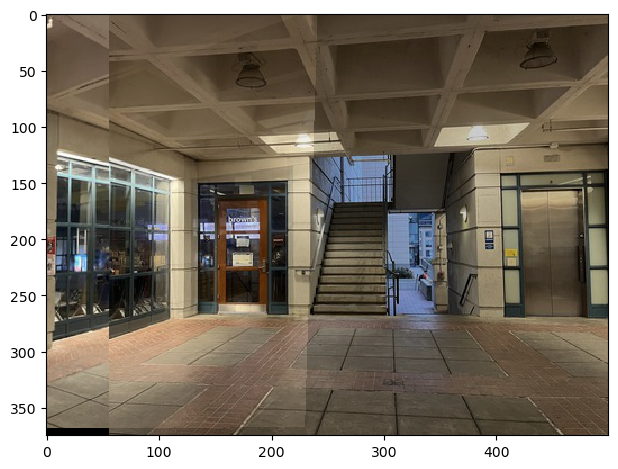

In [18]:
hallway0_hallway1 = ImagePointSet("hallway/hallway0_hallway1.json")
hallway0_hallway1.align_all_points()
hallway0_hallway1_projection_matrix = computeProjectionMatrix(hallway0_hallway1.points[0], hallway0_hallway1.points[1])
warped_hallway0_hallway1_image = warp_image(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix)
# hallway0_hallway1.display(True, figsize=(20, 8))

warped_hallway0_hallway1_alpha = np.ones(warped_hallway0_hallway1_image.shape[:2])
warped_hallway0_hallway1_alpha[:, np.min(hallway0_hallway1.points[1]):] = 0.2
skio.imshow(warped_hallway0_hallway1_alpha[:, :, np.newaxis] * warped_hallway0_hallway1_image + (1.0 - warped_hallway0_hallway1_alpha[:, :, np.newaxis]) * hallway0_hallway1.images[1])
skio.show()